# Take Home Assignment 1

## Problem Statement
**What qualities of crude oil lead to pipeline accidents?**

Pipelines are generally regarded as a safe way to transport fuel, a far better alternative to tanker trucks or freight trains. But when a pipeline does fail, the consequences can be catastrophic; since 1986, pipeline accidents have killed more than 500 people, injured over 4,000 and cost nearly seven billion dollars in property damage. 

Using any resources available to you, can you determine *what phyisical chemical properties* of crude oil could be responsible for pipeline accidents?

---


### Scoping and Assumptions

For scope, we are going to focus on pipelines within Canada, this is both due to the relevance of the problem and due to the data availability.

To tackle this question, first I will make some qualifying assumptions:

- We are going to assume all Canadian Crude has similar enough chemistry be considered as one product when analysing pipeline accidents
- We are going to assume that the differences in pipeline accident trends are solely influenced by the properties of the material and not external factors (operator, location, weather conditions, etc.)

### Backgrounder - What is a pipeline accident and why do they happen?

To answer why pipeline accidents happen, first we have to figure out what we mean when we say "accident". We will start by analysing the [pipeline incident dataset](https://open.canada.ca/data/en/dataset/7dffedc4-23fa-440c-a36d-adf5a6cc09f1) provided by the National Energy Board. This will provide us of an idea of what kind of incidents occured during the reporting period (2008-2025). Given that this is a dataset of all pipelines, not just crude oil, we might also get some insight into how or why incidents concerning crude oil are different than other petrochemicals.

In [76]:
!pip install folium

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium as fm
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

In [165]:
df_raw = pd.read_csv(filepath_or_buffer= 'data/in/pipeline-incidents-comprehensive-data.csv',encoding='utf-8', encoding_errors='ignore')

In [166]:
missing = df_raw.isnull().sum()
missing[missing>0]

Nearest Populated Centre                                                             2
Occurrence Date and Time                                                           458
Discovered Date and Time                                                             4
Detailed what happened                                                              27
Detailed why it happened                                                            28
                                                                                  ... 
Repair date                                                                       1743
Most recent inspection date for the failed equipment or component                 1626
Type of most recent inspection                                                    1627
Date of the most recent maintenance work for the failed equipment or component    1714
Most recent maintenance Type                                                      1668
Length: 66, dtype: int64

In [167]:
#do some data cleaning in the substances categories, this is not exactly perfect but good for a rough screen

df_raw['Substance carried'] = df_raw['Substance carried'].str.replace(r'.*Crude Oil.*', 'Crude Oil', regex=True)
df_raw['Substance carried'] = df_raw['Substance carried'].str.replace(r'.*Natural Gas.*', 'Natural Gas', regex=True)
df_raw['Substance carried'] = df_raw['Substance carried'].str.replace(r'^(?!.*(Crude Oil|Natural Gas)).*$', 'Other', regex=True)


#while there are other ways to interpolate data - for this project we are only going to look at pipelines where we know what they are carrying for sure
df = df_raw[df_raw['Substance carried'].notnull()].copy()

<Axes: xlabel='Number of Incidents', ylabel='Substance carried'>

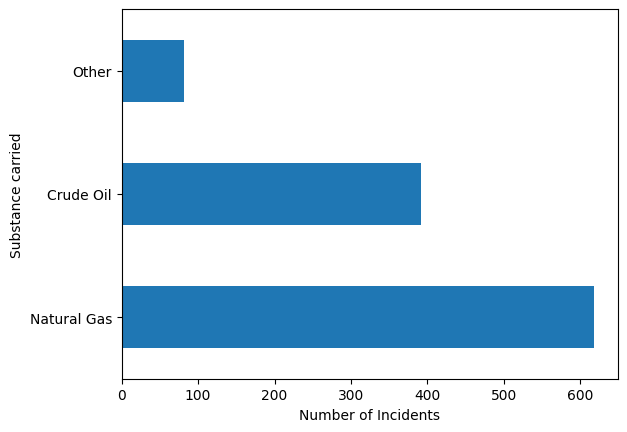

In [168]:
df['Substance carried'].value_counts().plot(xlabel='Number of Incidents',kind='barh')

In [177]:
idx = df[df['Substance carried']=='Other']
idx.index

Index([  23,   36,   41,   47,   48,   51,   97,  112,  120,  138,  152,  177,
        178,  179,  201,  271,  295,  296,  322,  374,  387,  396,  409,  597,
        598,  642,  659,  704,  709,  711,  730,  772,  773,  841,  843,  881,
        889,  921,  934,  967,  978, 1005, 1009, 1088, 1224, 1262, 1272, 1273,
       1274, 1275, 1277, 1278, 1282, 1283, 1284, 1285, 1328, 1337, 1354, 1375,
       1393, 1418, 1498, 1528, 1571, 1681, 1686, 1691, 1697, 1698, 1699, 1714,
       1774, 1784, 1790, 1837, 1838, 1841, 1865, 1900, 1901],
      dtype='int64')

In [ ]:
incident_counts = df['Incident Types'].value_counts(dropna=False)
incident_counts

Incident Types
Release of Substance                                   339
Operation Beyond Design Limits                         321
Fire                                                   260
Serious Injury (CER)                                    84
Adverse Environmental Effects                           59
Explosion                                               11
Fire, Release of Substance                               4
Explosion, Fire, Release of Substance                    3
Fatality                                                 3
Release of Substance, Adverse Environmental Effects      3
Explosion, Fire                                          2
Serious Injury (CER), Fire                               1
Name: count, dtype: int64

In [174]:
#drop some of the uncommon incidents to make results a bit more interpretable
valid_incidents = incident_counts[incident_counts>=5].index
df_incidents = df[df['Incident Types'].isin(valid_incidents)].copy()

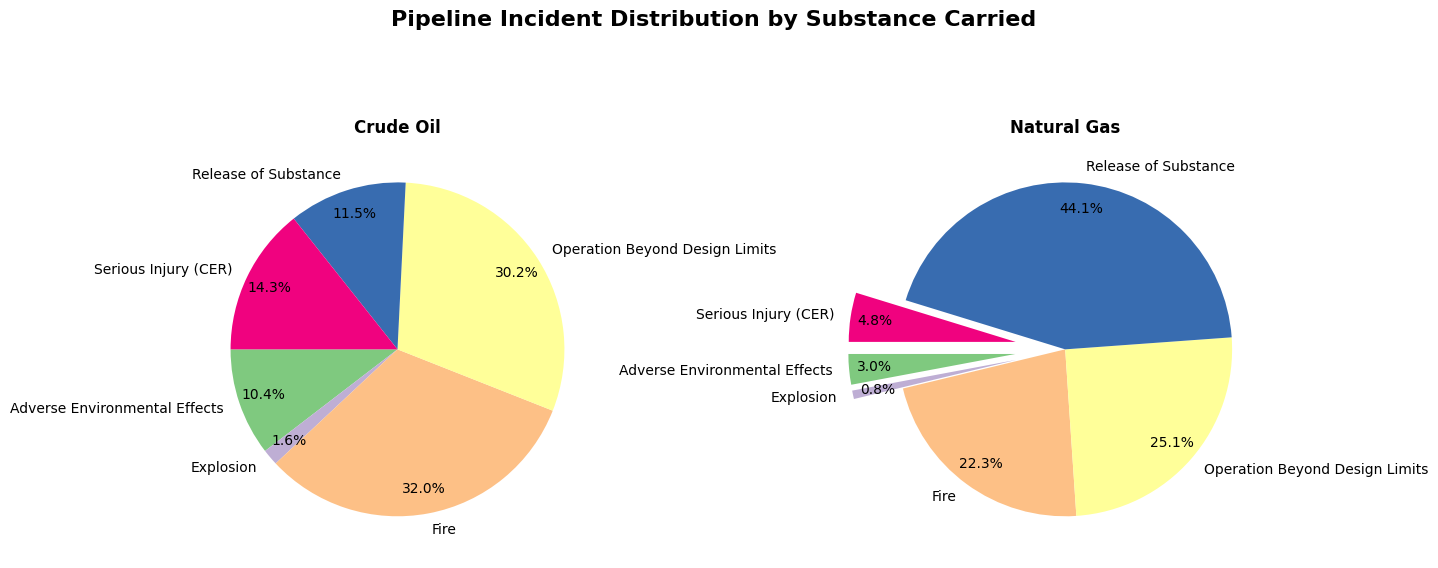

In [ ]:
#compare the incident frequency by substance carried
colours = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f']

pivot_df = pd.crosstab(df_incidents['Substance carried'], df_incidents['Incident Types'])


fig, axes = plt.subplots(1, 2, figsize=(14, 7))

#pie chart for crude oil
pivot_df.loc['Crude Oil'].plot(kind='pie', ax=axes[0], autopct='%1.1f%%', startangle=180, colors=colours,labeldistance=1.1, pctdistance=0.85)
axes[0].set_title('Crude Oil',fontweight='bold')
axes[0].set_ylabel('')

#pie chart for natural gas
pivot_df.loc['Natural Gas'].plot(kind='pie', ax=axes[1], autopct='%1.1f%%', startangle=180, colors=colours,labeldistance=1.1, pctdistance=0.85, explode = [0.3,0.3,0,0,0,0.3])
axes[1].set_title('Natural Gas',fontweight='bold')
axes[1].set_ylabel('')

fig.suptitle('Pipeline Incident Distribution by Substance Carried',fontsize=16, fontweight = 'bold')
fig.subplots_adjust(wspace=0.6)


plt.show()

In [186]:
pivot_df_other = pd.crosstab(df_incidents['Incident Types'],df_incidents['Substance carried'])
pivot_df_other.drop(columns = 'Other', inplace=True)
pivot_df_other

Substance carried,Crude Oil,Natural Gas
Incident Types,,
Adverse Environmental Effects,40,18
Explosion,6,5
Fire,123,136
Operation Beyond Design Limits,116,153
Release of Substance,44,269
Serious Injury (CER),55,29


Chi-Square Statistic: 139.8093642921533
P-Value: 1.9642225873981928e-28
Degrees of Freedom: 5
Expected Frequencies:
[[ 22.40643863  35.59356137]
 [  4.24949698   6.75050302]
 [100.05633803 158.94366197]
 [103.9195171  165.0804829 ]
 [120.91750503 192.08249497]
 [ 32.45070423  51.54929577]]


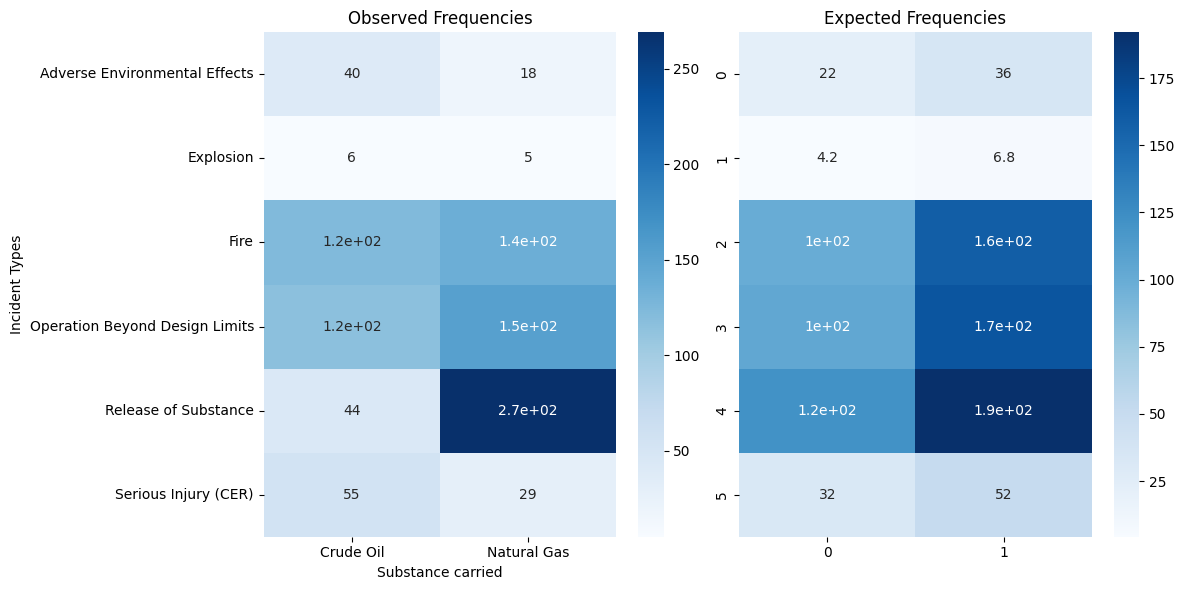

In [ ]:
#test if there is a significant difference between carrying crude oil in a pipeline in terms of accidents and carrying natural gas

#perform chi-square test
chi2, p, dof, expected = chi2_contingency(pivot_df_other)

print(f"chi-square statistic: {chi2}")
print(f"p value: {p}")
print(f"degrees of freedom: {dof}")
print("expected frequencies:")
print(expected)


fig, ax = plt.subplots(1, 2, figsize=(12, 6))

#plot the observed data
sns.heatmap(pivot_df_other, annot=True, cmap="Blues", ax=ax[0])
ax[0].set_title("Observed Frequencies")

#plot expected frequencies from chi-squared test
sns.heatmap(expected, annot=True, cmap="Blues", ax=ax[1])
ax[1].set_title("Expected Frequencies")

plt.tight_layout()
plt.show()


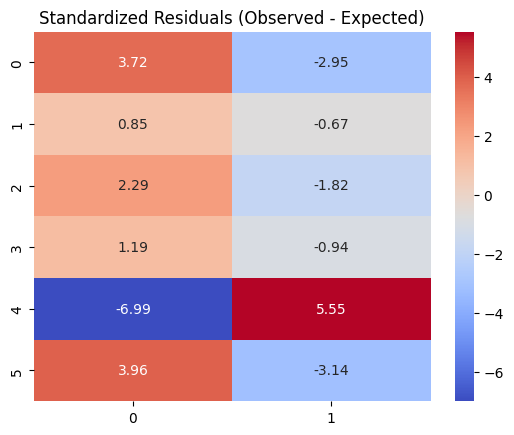

In [ ]:
#compute the standardized residuals to determine if there is a significantly higher or lower frequency of a given incident than one would expect (-2,2) is typically the range (2 stds)
residuals = pivot_df_other.values - expected

std_residuals = residuals / np.sqrt(expected)

sns.heatmap(std_residuals, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Standardized Residuals (Observed - Expected)")
plt.show()

In [ ]:
#instantiate map and get center
map_center = [df['Latitude'].mean(), df['Longitude'].mean()]
pipeline_map = fm.Map(location=map_center, zoom_start=3.5)

#plot incidents on map
for _, row in df[df['Substance carried']=='Crude Oil'].iterrows():
    fm.Marker([row['Latitude'], row['Longitude']]).add_to(pipeline_map)

display(pipeline_map)